# Chapter 3 - Train on Images

Here we will show how to train the model on a folder of images with ground truth age labels.

## Data Loader
Again, the first thing we need to do is define our dataloader (what kind of data we expect).  Different from chapter 2, we expect there to be an additional csv file with our age label information as well.  

Typically this data should be split into three different sets, a training set, a validation set, and a testing set.  The training set (\~ 60%-70%), as the name suggests is used to actually train the model.  The validation set (\~10%-20%) is used during training to choose the best performing model.  This is necessary since the model changes at each step of the training phase and the model at the very end of training may not be the best due to overfitting.  Finally, the testing set (\~ 10%-20%) is used to evaluate the actual model performance on unseen data (like accuracy).  For this example, we will use the same set of data for all three purposes.

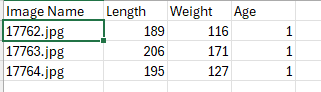

In [53]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data.dataset import Dataset  # For custom datasets
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import pandas as pd

class FishTestDataset(Dataset):
    def __init__(self, image_dir, csv_path, transform=None):

        # Read the csv file
        self.data_info = pd.read_csv(csv_path, header=0)
        
        # Get the directory dataset images
        self.image_dir = image_dir

        # Get the transform methods
        self.transforms = transform


        # Image Name
        self.image_name = np.asarray(self.data_info.iloc[:, 0])

        # Fish Age
        self.age = np.asarray(self.data_info.iloc[:, 3])


    def __len__(self):
        return len(self.image_name)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, str(self.image_name[index]))
        image = Image.open(img_path)
        
        if(self.age[index] < 5):
          label_age = self.age[index]
        else:
          label_age = 4
            
        if self.transforms:
            image = self.transforms(image)

        return image, self.image_name[index], label_age
        
data_dir = 'cropped'
csv_path = "train.csv"
data_transforms = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
train_dataset = FishTestDataset( data_dir, csv_path, data_transforms)
test_dataset = FishTestDataset( data_dir, csv_path, data_transforms)
val_dataset = FishTestDataset( data_dir, csv_path, data_transforms)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True, drop_last=False)
val_loader = DataLoader(test_dataset, batch_size=24, shuffle=False, drop_last=False)
test_loader = DataLoader(val_dataset, batch_size=24, shuffle=False, drop_last=False)

## Create and Load Pretrained Model
Before we can train the model, we first have to define the model architecture and load some pretrained weight.  We use pytorch resnet18 model and it's corresponding imagenet pretrained weights.  Using pretrained weights reduces training speed and can also improve final model performance if using limited training data.

In [54]:
from torchvision.models import resnet18, ResNet18_Weights, get_weight
from tqdm import tqdm
import torch 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = resnet18(num_classes = 5)
loaded_state_dict = torch.hub.load_state_dict_from_url("https://s3.amazonaws.com/pytorch/models/resnet18-5c106cde.pth")
current_model_dict = model.state_dict()
new_state_dict={k:v if v.size()==current_model_dict[k].size()  else  current_model_dict[k] for k,v in zip(current_model_dict.keys(), loaded_state_dict.values())}
model.load_state_dict(new_state_dict, strict = False)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training Hyperparameters
Before we start training, there are a few training parameters we need to define.  First is the number of training epochs, which is how many times we use the entire training set.  One epoch of training passes once we've gone through the training set once.  In each epoch, a training step is called an iteration, where N images are loaded at a time based on batch size.  
Another important hyperparameter is learning rate and learning rate schedule.  The learning rate determines how fast the model gets training.  Having a too large or too small learning rate can drastically affect final model performance.  Typically, as training progresses, learning rate is decreased through a learning rate scheduler.  In this case, at predefined epoch points, the learning rate is multiplied by gamma (<1).
Finally, we have to define what loss function we use for training.  For simple classification, we choose cross entropy loss.

In [55]:
import torch.nn as nn
num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 15, gamma=0.2)
criterion = nn.CrossEntropyLoss()

## Training the model
Now we train the model and also evaluate on the validation set at each epoch.  If validation accuracy at current epoch is better than previous epochs, the current model weights are saved as best_model.pth.  Finally, at the end of training, the final model weights are also saved as final_model.pth.  

In [60]:
import copy

best_acc = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_res = []

    running_loss = 0.0
    running_corrects = 0
    running_corr = [0.0, 0.0, 0.0, 0.0, 0.0]
    running_total = [0.0, 0.0, 0.0, 0.0, 0.0]
    for images, imagename, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

    
        # zero the parameter gradients
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            output = model(images)#inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
        # statistics
        _, preds = torch.max(output, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

        for i in range(0, len(preds)):
            if labels.data[i].cpu().detach().numpy() == 3:
                count_3 += 1

            if preds[i] == labels.data[i]:
                running_corr[int(labels.data[i].cpu().detach().numpy())] += 1.0
            running_total[int(labels.data[i].cpu().detach().numpy())] += 1.0
    scheduler.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100.0 * running_corrects / len(train_loader.dataset)
    running_res = [100.0 * i / max(1,j) for i, j in zip(running_corr, running_total)]
    print(running_res)
    print("{} Loss: {:.4f} Average Accuracy: {:.4f}".format("train", epoch_loss, epoch_acc))


    # Validation phase
    model.eval()
    running_res = []

    running_loss = 0.0
    running_corrects = 0
    running_corr = [0.0, 0.0, 0.0, 0.0, 0.0]
    running_total = [0.0, 0.0, 0.0, 0.0, 0.0]
    for images, imagename, labels in tqdm(val_loader):
    
        images = images.to(device)
        labels = labels.to(device)
    
        # zero the parameter gradients
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            output = model(images)#inputs)
            
        # statistics
        _, preds = torch.max(output, 1)
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)

        for i in range(0, len(preds)):
            if labels.data[i].cpu().detach().numpy() == 3:
                count_3 += 1

            if preds[i] == labels.data[i]:
                running_corr[int(labels.data[i].cpu().detach().numpy())] += 1.0
            running_total[int(labels.data[i].cpu().detach().numpy())] += 1.0
    scheduler.step()
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = 100.0 * running_corrects / len(val_loader.dataset)
    running_res = [100.0 * i / max(1,j) for i, j in zip(running_corr, running_total)]
    print(running_res)
    print("{} Loss: {:.4f} Average Accuracy: {:.4f}".format("validation", epoch_loss, epoch_acc))
    if(epoch_acc > best_acc):
        print("saving best model")
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        res = running_res.copy()
        torch.save(model.state_dict(), 'best_model.pth')

torch.save(model.state_dict(), 'final_model.pth')


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000
saving best model)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.39it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.13it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20.00it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.93it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.86it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.71it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.89it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.51it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.35it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.33it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.66it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.54it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.24it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.05it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.36it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.50it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.95it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.12it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.93it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.61it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.09it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.18it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.99it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.87it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14.08it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.70it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
train Loss: 0.0000 Average Accuracy: 100.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.23it/s]


[0.0, 100.0, 0.0, 0.0, 0.0]
validation Loss: 0.0000 Average Accuracy: 100.0000
